In [2]:
# Bibliotecas básicas
pip install scipy
import numpy as np
import gmsh
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# Visualização
import pyvista
from mpi4py import MPI
import matplotlib.pyplot as plt

# FEniCS
from ufl import (SpatialCoordinate, TestFunction, TrialFunction, as_vector,
                 dx, dot, grad)
from petsc4py import PETSc
from dolfinx import default_scalar_type
from dolfinx.mesh import locate_entities_boundary
from dolfinx.io import gmshio
from dolfinx.fem import (Constant, dirichletbc, Function, Expression, functionspace,
                         locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.plot import vtk_mesh
from dolfinx import fem, geometry

pyvista.start_xvfb()

ModuleNotFoundError: No module named 'scipy'

In [ ]:
# Geometria do eletropropulsor
R = 0.12e-3 / 2  # Raio do capilar [m]
d = 6e-3         # Distância capilar-eletrodo [m]
Ra = 2e-3        # Raio interno do eletrodo [m]
Rb = 9e-3        # Raio externo do eletrodo [m]
L = Rb - Ra      # Comprimento do eletrodo [m]
h = 0.05*L       # Altura do eletrodo [m]
y_capilar = 15e-4 # Comprimento do capilar [m]

# Domínio computacional
x_air = Rb
y_air = 9e-3

# Propriedades físicas
epsilon0 = 8.854e-12  # Permissividade do vácuo [F/m]
gamma = 0.05          # Tensão superficial [N/m]
epsr_ar = 1.0         # Permissividade relativa do ar
epsr_capilar = 84.0   # Permissividade relativa da formamida

In [3]:
rank = MPI.COMM_WORLD
gmsh.initialize()

gdim = 2
model_rank = 0
mesh_comm = MPI.COMM_WORLD

if mesh_comm.rank == model_rank:
    # Criar domínio de ar
    rectangle_air = gmsh.model.occ.addRectangle(0, 0, 0, x_air, y_air, tag=1)
    
    # Criar capilar (retângulo + semicírculo)
    rectangle = gmsh.model.occ.addRectangle(0, 0, 0, R, y_capilar, tag=2)
    circle = gmsh.model.occ.addDisk(0, y_capilar, 0, R, R)
    nozzle = gmsh.model.occ.fuse([(gdim, rectangle)], [(gdim, circle)])
    
    # Criar eletrodo
    eletrodo = gmsh.model.occ.addRectangle(Ra, d+y_capilar+R, 0, L, h, tag=4)
    
    # Fragmentar geometria
    ov, map_to_input = gmsh.model.occ.fragment([(gdim, rectangle_air)], 
                                               [(gdim, rectangle), (gdim, eletrodo)])
    gmsh.model.occ.synchronize()
    
    # Definir regiões físicas
    names = ["air", "capilar", "eletrodo"]
    for i in range(3):
        gmsh.model.addPhysicalGroup(gdim, tags=[ov[i][1]], tag=i+1, name=names[i])
    
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.0001)
    gmsh.model.mesh.generate(gdim)

# Converter para DOLFINx
mesh, cell_tags, facet_tags = gmshio.model_to_mesh(
    gmsh.model, comm=mesh_comm, rank=model_rank, gdim=gdim
)
mesh.topology.create_connectivity(gdim, gdim)
gmsh.finalize()

Info    : Cannot bind existing OpenCASCADE surface 2 to second tag 3                                                               
Info    : Could not preserve tag of 2D object 3 (->2)
Info    : Meshing 1D...                                                                                                  
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Ellipse)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 60%] Meshing curve 9 (Line)
Info    : [ 70%] Meshing curve 10 (Line)
Info    : [ 70%] Meshing curve 11 (Line)
Info    : [ 80%] Meshing curve 12 (Line)
Info    : [ 90%] Meshing curve 13 (Line)
Info    : [ 90%] Meshing curve 14 (Ellipse)
Info    : [100%] Meshing curve 15 (Line)
Info    : Done meshing 1D (Wall 0.00657554s, CPU 0.006799s)
Info    : Meshing 2D

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


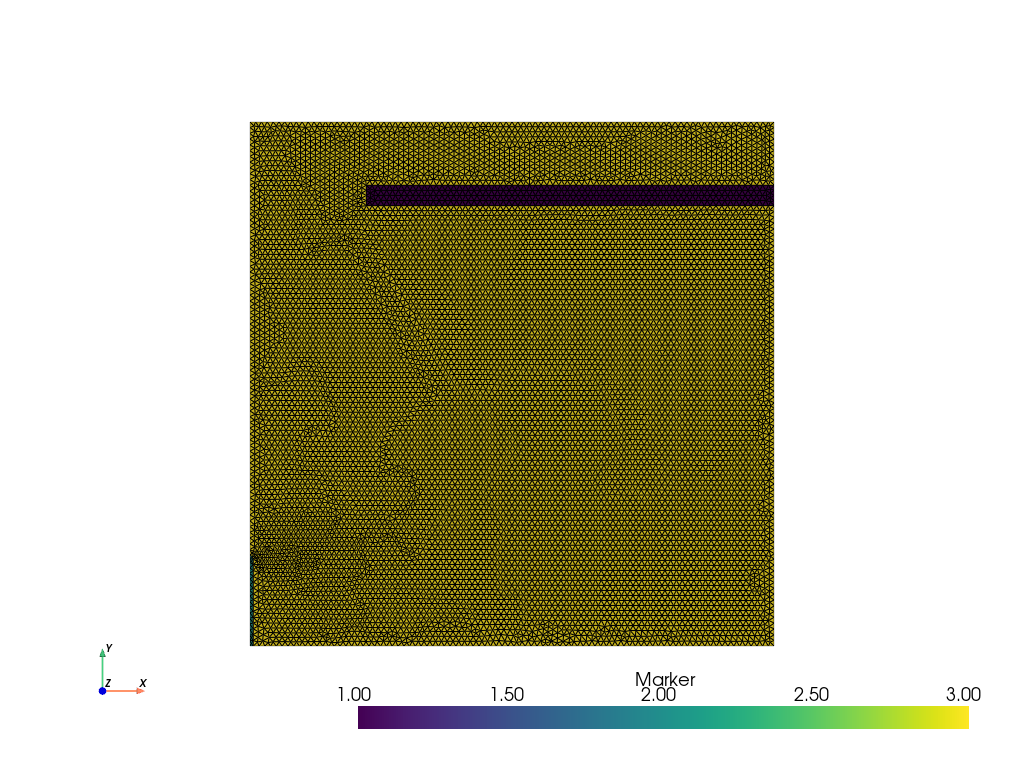

In [4]:
# Visualizar malha
topology, cell_types, x = vtk_mesh(mesh)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

plotter = pyvista.Plotter()
num_local_cells = mesh.topology.index_map(gdim).size_local
grid.cell_data["Marker"] = cell_tags.values[cell_tags.indices < num_local_cells]
grid.set_active_scalars("Marker")

actor = plotter.add_mesh(grid, show_edges=True, cmap="viridis", edge_color="black")
plotter.view_xy()
plotter.add_axes()
plotter.show()

In [5]:
# Definir permissividades por região
Q = fem.functionspace(mesh, ("DG", 0))
epsr = fem.Function(Q)

ar_elements = cell_tags.find(1)
capilar_elements = cell_tags.find(2)
eletrodo_elements = cell_tags.find(3)

epsr.x.array[ar_elements] = np.full_like(ar_elements, epsr_ar, dtype=default_scalar_type)
epsr.x.array[capilar_elements] = np.full_like(capilar_elements, epsr_capilar, dtype=default_scalar_type)
epsr.x.array[eletrodo_elements] = np.full_like(eletrodo_elements, epsr_ar, dtype=default_scalar_type)

# Tensão aplicada (crítica teórica)
V_aplicada = np.sqrt(gamma * R / epsilon0) * np.log(4 * d / R)
print(f"Tensão aplicada: {V_aplicada:.1f} V")

# Espaço de funções e coordenadas
V = fem.functionspace(mesh, ("Lagrange", 2))
tdim = mesh.topology.dim
x = SpatialCoordinate(mesh)
r = x[0]  # Coordenada radial

Tensão aplicada: 3487.6 V


In [6]:
# Definir fronteiras
def points_capilar(x):
    return (x[0] <= R) & (x[1] <= y_capilar+R)

def points_eletrodo(x):
    return (x[0] > Ra) & (x[1] >= d+y_capilar+R)

facets_capilar = locate_entities_boundary(mesh, tdim - 1, points_capilar)
facets_eletrodo = locate_entities_boundary(mesh, tdim - 1, points_eletrodo)

dofs_capilar = locate_dofs_topological(V, tdim - 1, facets_capilar)
dofs_eletrodo = locate_dofs_topological(V, tdim - 1, facets_eletrodo)

# Condições de contorno
bc_capilar = dirichletbc(PETSc.ScalarType(V_aplicada), dofs_capilar, V)
bc_eletrodo = dirichletbc(PETSc.ScalarType(0), dofs_eletrodo, V)
bcs = [bc_capilar, bc_eletrodo]

# Formulação variacional axissimétrica
phi = TrialFunction(V)
v = TestFunction(V)
a = epsr * r * dot(grad(phi), grad(v)) * dx
L = fem.Constant(mesh, PETSc.ScalarType(0)) * v * dx

# Resolver
phi_h = fem.Function(V)
problem = fem.petsc.LinearProblem(a, L, u=phi_h, bcs=bcs)
problem.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 2, gll_warped, unset, False, float64, [])), 1)

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


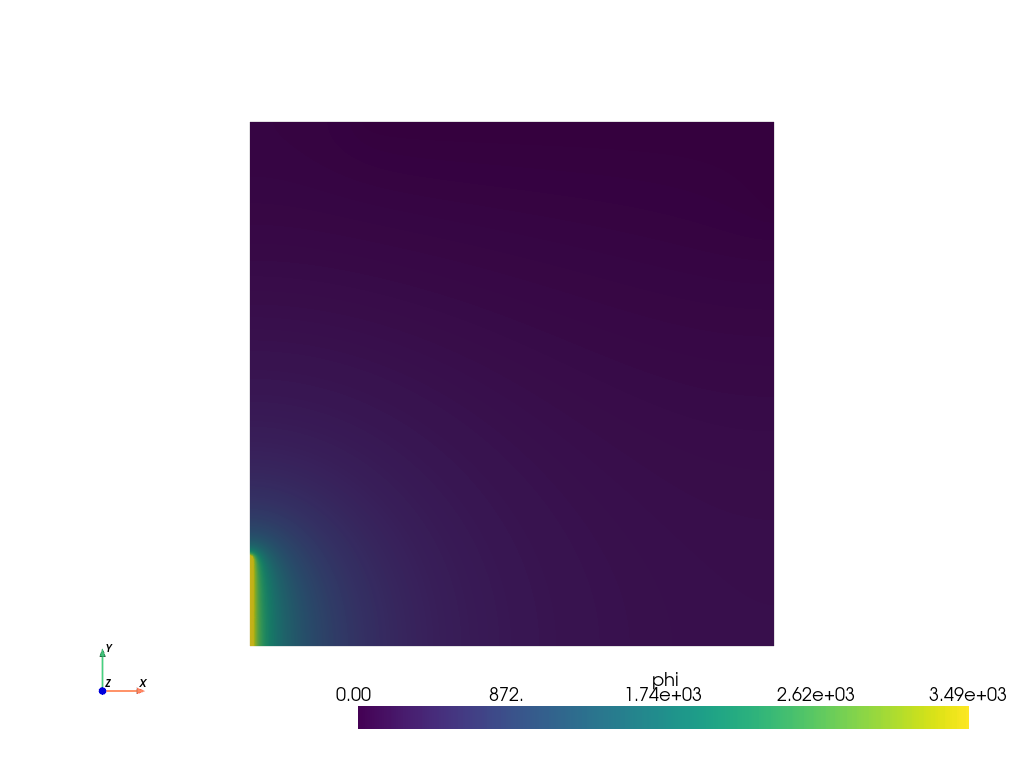

In [7]:
# Visualizar potencial elétrico
plotter = pyvista.Plotter()
phi_grid = pyvista.UnstructuredGrid(*vtk_mesh(V))
phi_grid.point_data["phi"] = phi_h.x.array
phi_grid.set_active_scalars("phi")

actor = plotter.add_mesh(phi_grid, show_edges=False, n_colors=256)
plotter.view_xy()
plotter.add_axes()
plotter.show()

In [8]:
# Calcular campo elétrico E = -∇φ
W = fem.functionspace(mesh, ("DG", 0, (mesh.geometry.dim,)))
E = fem.Function(W)
E_expr = fem.Expression(as_vector((-phi_h.dx(0), -phi_h.dx(1))), W.element.interpolation_points())
E.interpolate(E_expr)

# Análise dos resultados
phi_max = np.max(phi_h.x.array)
phi_min = np.min(phi_h.x.array)
E_magnitude = np.sqrt(E.x.array[::2]**2 + E.x.array[1::2]**2)
E_max = np.max(E_magnitude)

En_critico = np.sqrt(np.pi * gamma / (2 * epsilon0 * R))

print(f"Potencial: {phi_min:.2f} V ≤ φ ≤ {phi_max:.2f} V")
print(f"Campo elétrico máximo: {E_max:.2e} V/m")
print(f"Campo crítico teórico: {En_critico:.2e} V/m")
print(f"Razão E_max/E_crítico: {E_max/En_critico:.3f}")

Potencial: 0.00 V ≤ φ ≤ 3487.58 V
Campo elétrico máximo: 2.52e+07 V/m
Campo crítico teórico: 1.22e+07 V/m
Razão E_max/E_crítico: 2.071


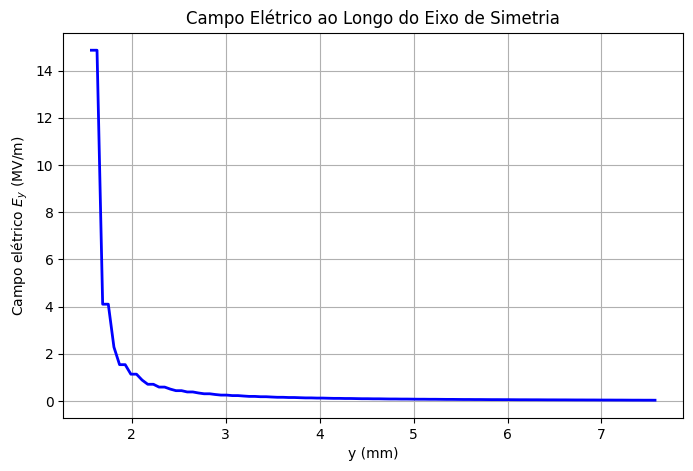

Campo elétrico na ponta do capilar: 1.49e+07 V/m


In [9]:
# Avaliar campo elétrico ao longo do eixo de simetria
bb_tree = geometry.bb_tree(mesh, mesh.topology.dim)

x_pos = 0  # Eixo de simetria
z_pos = 0
tol = 10e-6
y_start = y_capilar + R + tol
y_end = y_capilar + R + d + tol
n_points = 101

y_points = np.linspace(y_start, y_end, n_points)
points = np.zeros((3, n_points))
points[0, :] = x_pos
points[1, :] = y_points
points[2, :] = z_pos

# Encontrar células e avaliar campo
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)

points_on_proc = []
cells = []

for i, point in enumerate(points.T):
    linked_cells = colliding_cells.links(i)
    if len(linked_cells) > 0:
        points_on_proc.append(point)
        cells.append(linked_cells[0])

points_on_proc = np.array(points_on_proc, dtype=np.float64)
E_values = E.eval(points_on_proc, cells)

E_x = np.array([val[0] for val in E_values])
E_y = np.array([val[1] for val in E_values])
y_sampled = points_on_proc[:, 1]

# Plot do campo elétrico
plt.figure(figsize=(8, 5))
plt.plot(y_sampled*1e3, E_y/1e6, 'b-', linewidth=2)
plt.xlabel('y (mm)')
plt.ylabel('Campo elétrico $E_y$ (MV/m)')
plt.title('Campo Elétrico ao Longo do Eixo de Simetria')
plt.grid(True)
plt.show()

print(f"Campo elétrico na ponta do capilar: {E_y[0]:.2e} V/m")

In [10]:
# Parâmetros da gotícula
Rg = 0.002e-3      # Raio da gotícula [m]
rho = 1130         # Densidade da formamida [kg/m³]
m = (4/3) * np.pi * Rg**3 * rho  # Massa da gotícula
Q = 8 * np.pi * np.sqrt(epsilon0 * gamma) * Rg**(3/2)  # Carga da gotícula

print(f"Massa da gotícula: {m*1e15:.2f} fg")
print(f"Carga da gotícula: {Q*1e18:.2f} aC")

# Força elétrica e interpolação
Fe = Q * E_y
Fe_interp = interp1d(y_sampled, Fe, kind='linear', bounds_error=False, fill_value=0)

# Sistema dinâmico
def sistema(t, estado):
    y_pos, velocidade = estado
    Fe_atual = Fe_interp(y_pos)
    aceleracao = Fe_atual / m
    return [velocidade, aceleracao]

# Resolver EDO
y0 = y_sampled[0]
v0 = 0
estado_inicial = [y0, v0]
y_final = y_sampled[-1]
t_max = 2e-3

def evento_eletrodo(t, estado):
    return estado[0] - y_final

evento_eletrodo.terminal = True
evento_eletrodo.direction = 1

sol = solve_ivp(sistema, [0, t_max], estado_inicial, events=evento_eletrodo, 
                dense_output=True, method='RK45', rtol=1e-6)

# Resultados
if sol.t_events[0].size > 0:
    t_final = sol.t_events[0][0]
    v_final = sol.y_events[0][0][1]
    print(f"\nVelocidade de saída: {v_final:.1f} m/s")
    print(f"Tempo de voo: {t_final*1e6:.1f} μs")
else:
    v_final = sol.y[1, -1]
    print(f"\nVelocidade final: {v_final:.1f} m/s")

Massa da gotícula: 37.87 fg
Carga da gotícula: 47297.66 aC

Velocidade de saída: 88.5 m/s
Tempo de voo: 73.6 μs


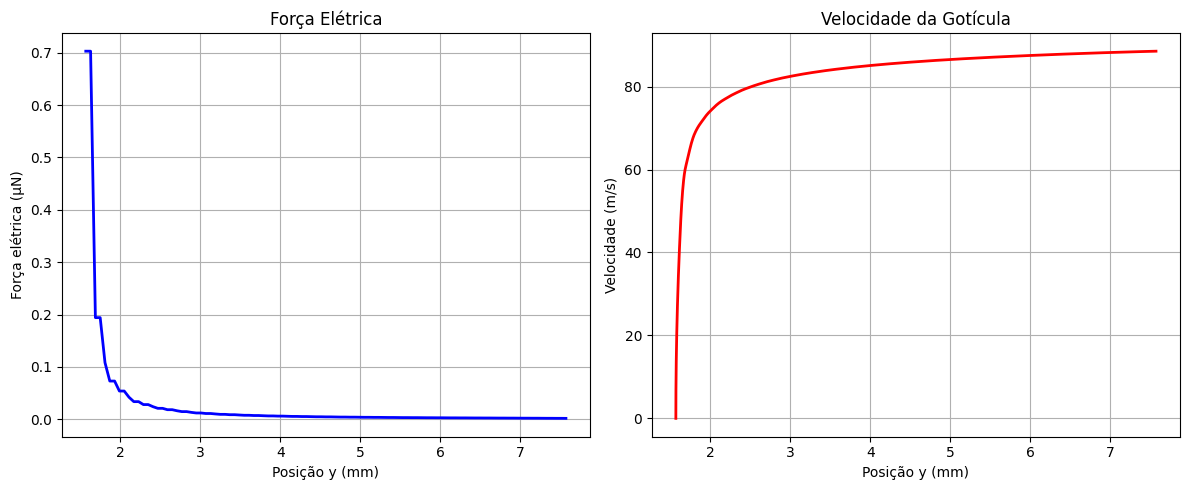

Força elétrica máxima: 0.70 μN
Aceleração máxima: 1.86e+07 m/s²


In [11]:
# Plotar força e velocidade
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Força elétrica vs posição
ax1.plot(y_sampled*1e3, Fe*1e6, 'b-', linewidth=2)
ax1.set_xlabel('Posição y (mm)')
ax1.set_ylabel('Força elétrica (μN)')
ax1.set_title('Força Elétrica')
ax1.grid(True)

# Velocidade vs posição
t_dense = np.linspace(0, sol.t[-1], 1000)
estado_dense = sol.sol(t_dense)
pos_dense = estado_dense[0, :]
vel_dense = estado_dense[1, :]

ax2.plot(pos_dense*1e3, vel_dense, 'r-', linewidth=2)
ax2.set_xlabel('Posição y (mm)')
ax2.set_ylabel('Velocidade (m/s)')
ax2.set_title('Velocidade da Gotícula')
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Força elétrica máxima: {np.max(Fe)*1e6:.2f} μN")
print(f"Aceleração máxima: {np.max(Fe)/m:.2e} m/s²")